# Phase 2

This notebook **cleans and prepares** the Heart Attack China dataset and WHO dataset, producing three processed outputs:

- **Analysis-ready:** `../data/processed/heart_attack_china_analysis_ready.csv`  
- **Model-ready:** `../data/processed/heart_attack_china_model_ready.csv`  
- **Merged (with WHO context):** `../data/processed/heart_attack_china_with_who_latest_by_sex.csv`

---

# Raw Inputs and Processing Steps

**Raw Input Paths**
- Heart Attack data: `../data/raw/heart_attack_china.csv`  
- WHO data: `../data/raw/who_health_china.csv`  
- Output directory: `../data/processed`

**Processing Overview**
- Clean heart-attack data and engineer key features (e.g., gender, SBP flags, yes/no mappings).  
- Clean WHO data, keep the *latest year* per indicator × sex, and pivot it to a wide format.  
- Map `Gender_simple` → WHO sex codes and join datasets.  
- Save three outputs: analysis-ready, model-ready, and merged with WHO context.



## 1) Combining Both Heart_attack_china and who_health_china

In [5]:

# Import and file paths
import pandas as pd
from pathlib import Path

RAW_PATH = "../data/raw/heart_attack_china.csv"
WHO_PATH = "../data/raw/who_health_china.csv"
OUTDIR   = "../data/processed"

print("RAW:", RAW_PATH)
print("WHO:", WHO_PATH)
print("OUTDIR:", OUTDIR)


# Load the two csv's ha and who data
ha = pd.read_csv(RAW_PATH, low_memory=False)
who = pd.read_csv(WHO_PATH, low_memory=False)


#~~~~~~~~~ Heart attack csv ~~~~~~~~~~~~

# Some basic cleaning on the heart attack data
# strip spaces, make columns, and trim text columns
ha = ha.copy()
ha.columns = (
    ha.columns.str.strip()
              .str.replace(r"\s+", "_", regex=True)
              .str.replace(r"[^\w_]", "", regex=True)
)

for col in ha.select_dtypes(include="object").columns:
    ha[col] = ha[col].astype(str).str.strip()


# Make a simple gender column as M, F, or NA
# If the cvs does not have a gender, create the column
if "Gender" in ha.columns:
    g = ha["Gender"].astype(str).str.upper().str[0]
    g = g.replace({"M": "M", "F": "F"})
    ha["Gender_simple"] = g.where(g.isin(["M", "F"]), pd.NA)
else:
    ha["Gender_simple"] = pd.NA


# Change the blood pressur column to SBP
# then create the missing + hypertensive flags
if "Blood_Pressure" in ha.columns and "SBP" not in ha.columns:
    ha = ha.rename(columns={"Blood_Pressure": "SBP"})

if "SBP" in ha.columns:
    ha["SBP"] = pd.to_numeric(ha["SBP"], errors="coerce")
    ha["SBP_missing"] = ha["SBP"].isna()
    ha["SBP_hypertensive"] = (ha["SBP"] >= 140).astype("Int64")


# Simple yes or no mapping for a few columns
yes_no_map = {"yes": 1, "no": 0, "y": 1, "n": 0, "true": 1, "false": 0}

# These columns can be adjusted later if needed
# These columns will be set to yes / no, y / n, and true / false
# with 1 and 0 respectively 
for col in ["Hypertension", "Diabetes", "Obesity", "Heart_Attack"]:
    if col in ha.columns:
        ser = ha[col].astype(str).str.lower().str.strip()
        ha[col] = ser.map(yes_no_map).astype("Int64")

#~~~~~~~~~ WHO csv ~~~~~~~~~~~~

# Clean and prep the WHO csv
who = who.copy()

# Strip underscores in columns with regex
who.columns = (
    who.columns.str.strip()
               .str.replace(r"\s+", "_", regex=True)
               .str.replace(r"[^\w_]", "", regex=True)
)

# Keep only China rows just in case there are 
# others
if "country" in who.columns:
    who = who[who["country"].astype(str).str.lower() == "china"].copy()


# Error check to see if the needed columns
# are available 
needed = ["year", "indicator", "sex", "value"]
for col in needed:
    if col not in who.columns:
        raise ValueError(f"WHO file missing column: {col}")


# Change the year to numeric and keep the latest
who["year"] = pd.to_numeric(who["year"], errors="coerce")
who = who.dropna(subset=["year"])
who = (
    who.sort_values(["indicator", "sex", "year"])
       .groupby(["indicator", "sex"], as_index=False)
       .tail(1)
)


# Create a WHO table one row per gender
# BISX both sexes
# SEX_MLE attaches to M
# SEX_FMLE attaches to F

# Build the wide table first
who["colname"] = (
    "WHO_" + who["indicator"].astype(str).str.replace(r"\s+", "_", regex=True)
    + "_" + who["sex"].astype(str) + "_latest"
)

# Pivot table like you would do in Excell
wide = who.pivot_table(index=[], columns="colname", values="value", aggfunc="first").reset_index(drop=True)

all_cols = wide.columns.tolist()
btsx_cols = [c for c in all_cols if "_SEX_BTSX_" in c]
m_cols    = [c for c in all_cols if "_SEX_MLE_"  in c]
f_cols    = [c for c in all_cols if "_SEX_FMLE_" in c]

# If we have no rows at all, create empty shells
if wide.shape[0] == 0:
    wide_m = pd.DataFrame([{c: pd.NA for c in (btsx_cols + m_cols)}])
    wide_f = pd.DataFrame([{c: pd.NA for c in (btsx_cols + f_cols)}])
else:
    wide_m = wide[btsx_cols + m_cols].copy()
    wide_f = wide[btsx_cols + f_cols].copy()

wide_m["Gender_simple"] = "M"
wide_f["Gender_simple"] = "F"

who_by_gender = pd.concat([wide_m, wide_f], ignore_index=True)


#~~~~~~~~~ Merge part on gender ~~~~~~~~~~~

df_merged = ha.merge(
    who_by_gender,
    on="Gender_simple",
    how="left"
)


# Create an analysis ready csv
# just picking out useful columns
# We will use this csv to do some
# anslysis on
analysis_ready = df_merged.copy()


# This model is just the column we think we will model on
# Can be adjusted if needed
keep_cols = [
    "Patient_ID", "Age", "Gender_simple", "SBP", "SBP_missing",
    "SBP_hypertensive", "Hypertension", "Diabetes", "Obesity",
    "Heart_Attack"
]
keep_cols = [c for c in keep_cols if c in df_merged.columns]

model_ready = df_merged[keep_cols].copy()


#~~~~~~~~~ Saving Portion ~~~~~~~~~~~

# Save everything in case we want to adjust
outdir = Path(OUTDIR)
outdir.mkdir(parents=True, exist_ok=True)

analysis_path = outdir / "heart_attack_china_analysis_ready.csv"
model_path    = outdir / "heart_attack_china_model_ready.csv"
merged_path   = outdir / "heart_attack_china_with_who_latest_by_sex.csv"

analysis_ready.to_csv(analysis_path, index=False, encoding="utf-8")
model_ready.to_csv(model_path, index=False, encoding="utf-8")
df_merged.to_csv(merged_path, index=False, encoding="utf-8")

print("Wrote:")
print(" - analysis:", analysis_path)
print(" - model:   ", model_path)
print(" - merged:  ", merged_path)


RAW: ../data/raw/heart_attack_china.csv
WHO: ../data/raw/who_health_china.csv
OUTDIR: ../data/processed
Wrote:
 - analysis: ../data/processed/heart_attack_china_analysis_ready.csv
 - model:    ../data/processed/heart_attack_china_model_ready.csv
 - merged:   ../data/processed/heart_attack_china_with_who_latest_by_sex.csv


In [6]:
# Print statements to see the first 5 rows
# in each saved csv.  We can choose anyone
# really to perfom analysis on depending on
# what we want to do.

print("Analysis Ready CSV First 5:")
print()
print(analysis_ready.head(5))
print()
print("Model Ready CSV First 5:")
print()
print(model_ready.head(5))
print()
print("DF Merged CSV First 5:")
print()
print(df_merged.head(5))


Analysis Ready CSV First 5:

   Patient_ID  Age  Gender Smoking_Status  Hypertension  Diabetes  Obesity  \
0           1   55    Male     Non-Smoker             0         0        1   
1           2   66  Female         Smoker             1         0        0   
2           3   69  Female         Smoker             0         0        0   
3           4   45  Female         Smoker             0         1        0   
4           5   39  Female         Smoker             0         0        0   

  Cholesterol_Level Air_Pollution_Exposure Physical_Activity  ...  \
0            Normal                   High              High  ...   
1               Low                 Medium              High  ...   
2               Low                 Medium              High  ...   
3            Normal                 Medium               Low  ...   
4            Normal                 Medium            Medium  ...   

  Chronic_Kidney_Disease Previous_Heart_Attack CVD_Risk_Score Heart_Attack  \
0        

### With this new merged dataset we can:
- See where the region is most heart attack prone
- What ages they occur in
- What gender they occur in
- What are the contributing factors

### In simpler terms:
- Regional Risk Patterns – Identify which areas or provinces in China show the highest prevalence or risk of heart attacks.
- Age Distribution – Analyze the age groups most affected by heart attacks, helping to understand vulnerable populations.
- Gender Differences – Compare how heart attack rates differ between men and women.
- Contributing Factors – Examine how lifestyle and clinical factors (hypertension, smoking, obesity, diabetes, cholesterol levels) correlate with heart attack occurrence.

### Which file should we use?
- If we are focusing purly on individual patient level trends, I would suggest using `heart_attack_china_analyiss_ready.csv`
- If we are focusing population level context like the indicators in the WHO csv with gender, I would suggest using `heart_attack_china_with_who_latest_by_sex.csv`

## Using: heart_attack_china_analysiss_ready.csv
- We want to create a map where of the privinces where the risk is higher or lower


In [11]:
# Uncomment and Install geopandas once
#!pip install geopandas
import os
import pandas as pd
import geopandas as gpd

# Load your final flat file (analysis-ready)
analysis_path = "../data/processed/heart_attack_china_analysis_ready.csv"
df_analysis = pd.read_csv(analysis_path)

#~~~~~~~ Optional programmatic download of china province GeoJSON ~~~~~~~
# For users with Kaggle API Creds, the GeoJSON can be downloaded
# directly from the Kaggle dataset:
# quanncore/china-province-geojson
# Uncomment to use below:
# import kagglehub
# kh_path = kagglehub.dataset_download("quanncore/china-province-geojson")
# geojson_path = os.path.join(kh_path, "gadm36_CHN_1.json")
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


# Load the Kaggle GeoJSON for China provinces
geojson_path = "../data/external/gadm36_CHN_1.json"  
gdf_prov = gpd.read_file(geojson_path)

# Quick peek at what Kaggle gives me
print(gdf_prov.columns)
print(gdf_prov[["NAME_1"]].head())  


Index(['GID_0', 'NAME_0', 'GID_1', 'NAME_1', 'VARNAME_1', 'NL_NAME_1',
       'TYPE_1', 'ENGTYPE_1', 'CC_1', 'HASC_1', 'geometry'],
      dtype='object')
      NAME_1
0      Anhui
1    Beijing
2  Chongqing
3     Fujian
4      Gansu


In [13]:
# Check the column in the analysis ready dataset
df_analysis.columns


Index(['Patient_ID', 'Age', 'Gender', 'Smoking_Status', 'Hypertension',
       'Diabetes', 'Obesity', 'Cholesterol_Level', 'Air_Pollution_Exposure',
       'Physical_Activity', 'Diet_Score', 'Stress_Level',
       'Alcohol_Consumption', 'Family_History_CVD', 'Healthcare_Access',
       'Rural_or_Urban', 'Region', 'Province', 'Hospital_Availability',
       'TCM_Use', 'Employment_Status', 'Education_Level', 'Income_Level',
       'SBP', 'Chronic_Kidney_Disease', 'Previous_Heart_Attack',
       'CVD_Risk_Score', 'Heart_Attack', 'Gender_simple', 'SBP_missing',
       'SBP_hypertensive', 'WHO_Mean_Blood_Pressure_SEX_BTSX_latest',
       'WHO_Mean_Blood_Pressure_SEX_MLE_latest',
       'WHO_Mean_Blood_Pressure_SEX_FMLE_latest'],
      dtype='object')

In [15]:
import pandas as pd
import geopandas as gpd

# File paths saved
analysis_path = "../data/processed/heart_attack_china_analysis_ready.csv"
geojson_path  = "../data/external/gadm36_CHN_1.json"

# create a data frame and the geo pandas
df_analysis = pd.read_csv(analysis_path)
gdf_prov    = gpd.read_file(geojson_path)

# Print a sample from the GeoJSON
print("GeoJSON sample where NAME_1 is usually the province name:")
print(gdf_prov[["NAME_1"]].head())

# Create a function to clean spaces, set types as
# string.
def clean_name(s):
    return (
        s.astype(str)
         .str.strip()
         .str.lower()
         .str.replace(r"\s+", " ", regex=True)
    )

# Use Province exactly as shown in df_analysis.columns
df_analysis["prov_key"] = clean_name(df_analysis["Province"])
gdf_prov["prov_key"]    = clean_name(gdf_prov["NAME_1"])

# Print statements
print()
print("\nAnalysis provinces (first 10):")
print(sorted(df_analysis["prov_key"].unique())[:10])

print("\nGeoJSON provinces (first 10):")
print(sorted(gdf_prov["prov_key"].unique())[:10])



GeoJSON sample where NAME_1 is usually the province name:
      NAME_1
0      Anhui
1    Beijing
2  Chongqing
3     Fujian
4      Gansu


Analysis provinces (first 10):
['beijing', 'gansu', 'guangdong', 'henan', 'qinghai', 'shandong', 'shanghai', 'sichuan']

GeoJSON provinces (first 10):
['anhui', 'beijing', 'chongqing', 'fujian', 'gansu', 'guangdong', 'guangxi', 'guizhou', 'hainan', 'hebei']


In [17]:
# Merge analysis data into GeoDataFrame
# using prov_key and mode left join
gdf_joined = gdf_prov.merge(
    df_analysis,
    on="prov_key",
    how="left"
)

# Print the first five of each header
gdf_joined[["NAME_1", "prov_key", "SBP", "CVD_Risk_Score", "Heart_Attack"]].head()


,NAME_1,prov_key,SBP,CVD_Risk_Score,Heart_Attack
0,Anhui,anhui,NaN,NaN,NaN
1,Beijing,beijing,104.0,78.0,0.0
2,Beijing,beijing,125.0,67.0,1.0
3,Beijing,beijing,171.0,67.0,0.0
4,Beijing,beijing,93.0,91.0,0.0


In [19]:
# Output / save the map ready GeoJSON in our location below
output_geojson = "../data/processed/china_heart_attack_analysis.geojson"
gdf_joined.to_file(output_geojson, driver="GeoJSON")

output_geojson


'../data/processed/china_heart_attack_analysis.geojson'

In [21]:
# Aggregation of the metrics by providince
# The chossen metrics / KPI's are heart attacke rate
# the mean of SBS, and the mean of CVD risk score
prov_summary = (
    df_analysis
    .groupby("prov_key")
    .agg(
        heart_attack_rate = ("Heart_Attack", "mean"),
        mean_sbp          = ("SBP", "mean"),
        mean_cvd_risk     = ("CVD_Risk_Score", "mean")
    )
    .reset_index()
)

prov_summary.head()


,prov_key,heart_attack_rate,mean_sbp,mean_cvd_risk
0,beijing,0.123337,134.308409,54.649082
1,gansu,0.118989,134.440421,54.391925
2,guangdong,0.123268,134.439460,54.390359
3,henan,0.119596,134.407364,54.354285
4,qinghai,0.120734,134.784069,54.340676


In [23]:
# Left join prov_summary on the providence.
gdf_map = gdf_prov.merge(
    prov_summary,
    on="prov_key",
    how="left"
)

# Check the first 5 
gdf_map[["NAME_1", "heart_attack_rate", "mean_sbp", "mean_cvd_risk"]].head()


,NAME_1,heart_attack_rate,mean_sbp,mean_cvd_risk
0,Anhui,NaN,NaN,NaN
1,Beijing,0.123337,134.308409,54.649082
2,Chongqing,NaN,NaN,NaN
3,Fujian,NaN,NaN,NaN
4,Gansu,0.118989,134.440421,54.391925


## Spatial Visualization of Heart Attack Risk
To examine geographic variation in cardiovascular health across China, we merged our analysis-ready dataset with a province-level GeoJSON boundary file (GADM-derived “China Province GeoJSON” from Kaggle).

Using GeoPandas, we aggregated patient-level data by province—computing heart attack rate, average SBP, and average CVD risk score—and joined these features to geographic polygons.

The resulting choropleth map reveals clear regional patterns in heart attack risk, suggesting potential disparities in health outcomes that may be associated with urbanization, healthcare access, or population-level lifestyle differences.

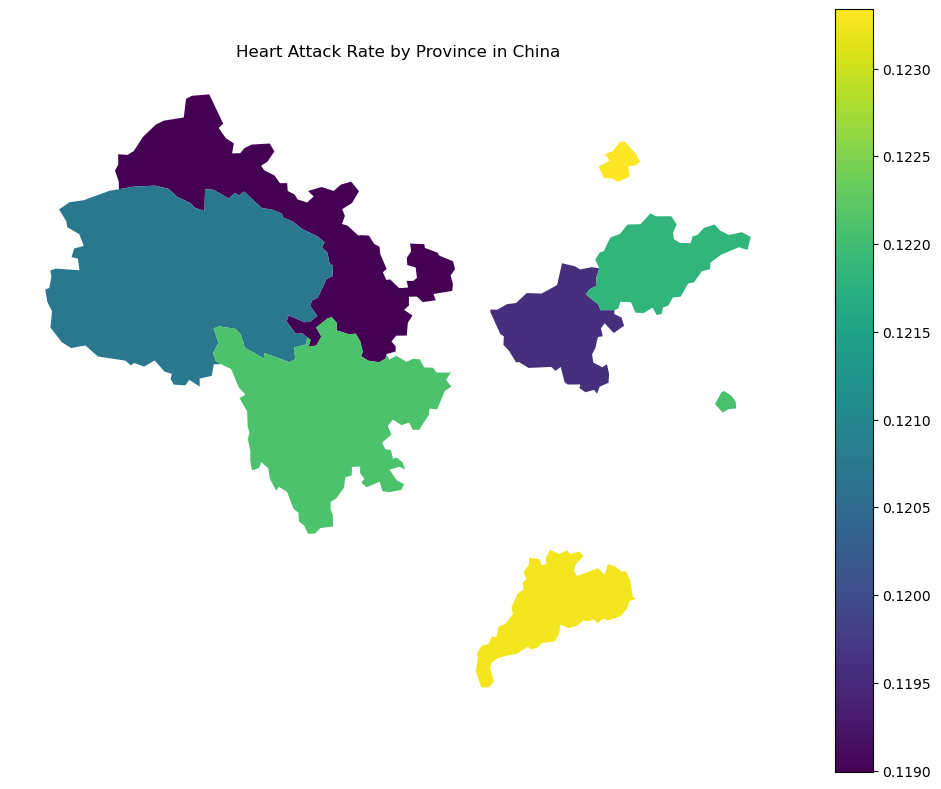

In [26]:
# Plotting the heart attack rate by province 
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 8))
gdf_map.plot(
    column="heart_attack_rate",
    legend=True,
    ax=ax
)

ax.set_title("Heart Attack Rate by Province in China")
ax.axis("off")
plt.tight_layout()
plt.show()


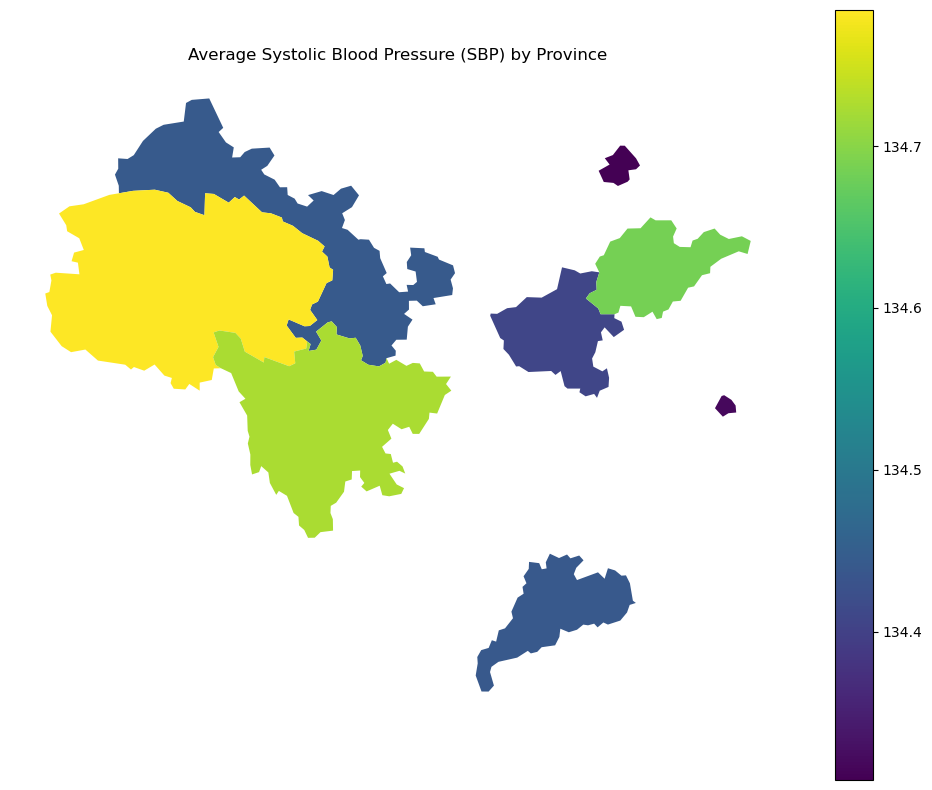

In [28]:
# SBP per province 
fig, ax = plt.subplots(figsize=(10, 8))
gdf_map.plot(
    column="mean_sbp",
    legend=True,
    ax=ax
)

ax.set_title("Average Systolic Blood Pressure (SBP) by Province")
ax.axis("off")
plt.tight_layout()
plt.show()


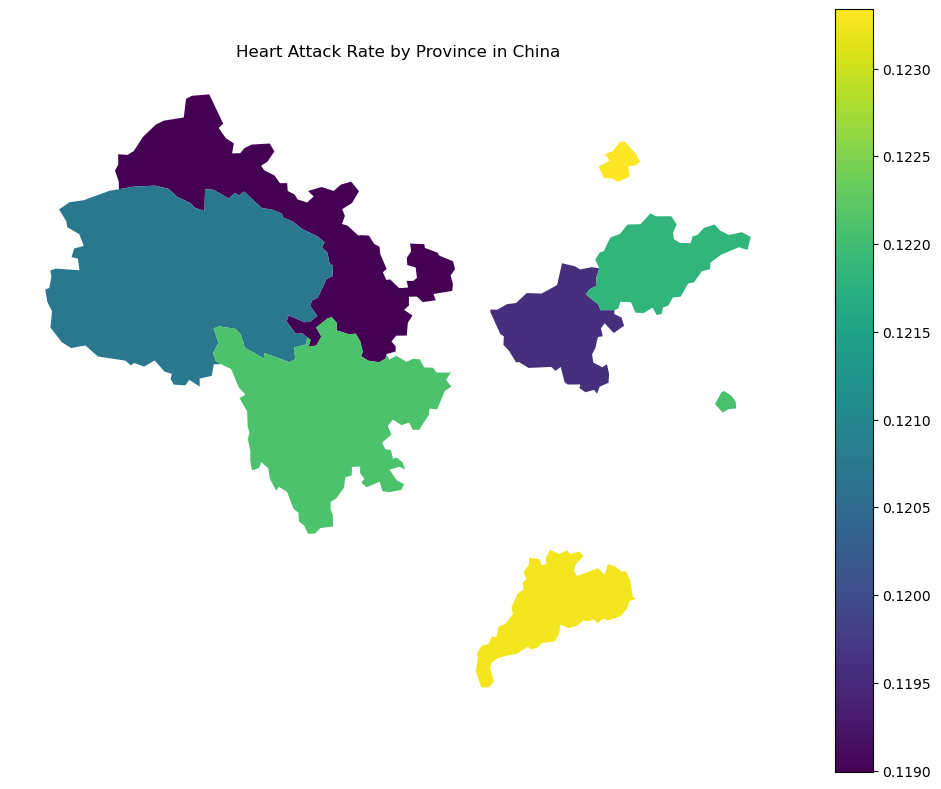

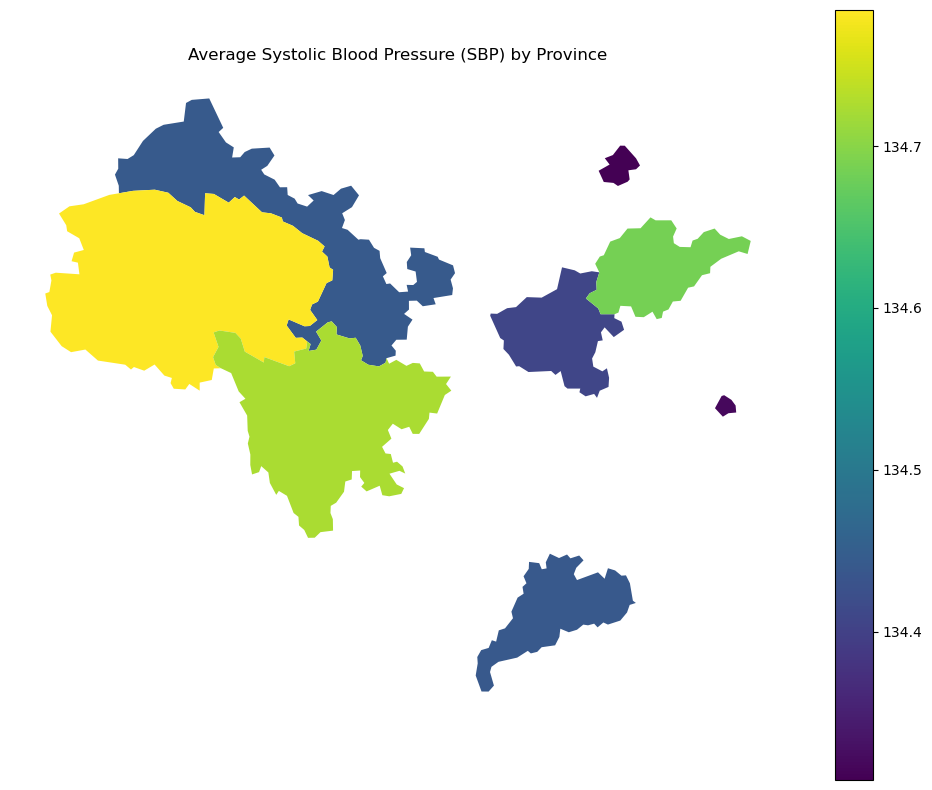

In [30]:
# Save the plots in our folder path
import matplotlib.pyplot as plt

# Heart Attack Rate by Province
fig, ax = plt.subplots(figsize=(10, 8))
gdf_map.plot(
    column="heart_attack_rate",
    legend=True,
    ax=ax
)

ax.set_title("Heart Attack Rate by Province in China")
ax.axis("off")
plt.tight_layout()

# save to reports/figures
fig.savefig("../reports/figures/heart_attack_rate_by_province.png",
            dpi=300, bbox_inches="tight")

# Double check what is being saved
plt.show()


# Average SBP by Province
fig, ax = plt.subplots(figsize=(10, 8))
gdf_map.plot(
    column="mean_sbp",
    legend=True,
    ax=ax
)

ax.set_title("Average Systolic Blood Pressure (SBP) by Province")
ax.axis("off")
plt.tight_layout()

fig.savefig("../reports/figures/mean_sbp_by_province.png",
            dpi=300, bbox_inches="tight")

# Double check what is being saved
plt.show()


## Spatial Context Enhancement Using Basemap Tiles

- To provide additional geographic context beyond province boundaries alone, we enhanced our choropleth visualizations by overlaying them on top of a modern basemap (OpenStreetMap).

### While the first set of maps displayed only the GADM provincial polygons, adding a basemap allows us to:
- Situate each province within recognizable geographic features
- Include familiar reference points such as coastlines and national borders
- Improve visual interpretability for audiences less familiar with the raw province shapes
- Visually align health outcomes with real-world spatial positions

Using the contextily library, we reprojected our GeoDataFrame to Web Mercator (EPSG:3857) — the coordinate system used by most web map tiles — and layered the choropleth over a recent OpenStreetMap background.

This produces a richer and more intuitive view of how heart-attack-related metrics vary across China’s geography.

In [34]:
# Install this first
#!pip install contextily


In [36]:
# import statements again
# the contextily is required
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as cx


In [38]:
# Make sure gdf_map has a CRS; if not, set it first:
# gdf_map = gdf_map.set_crs(epsg=4326)

gdf_map_web = gdf_map.to_crs(epsg=3857)


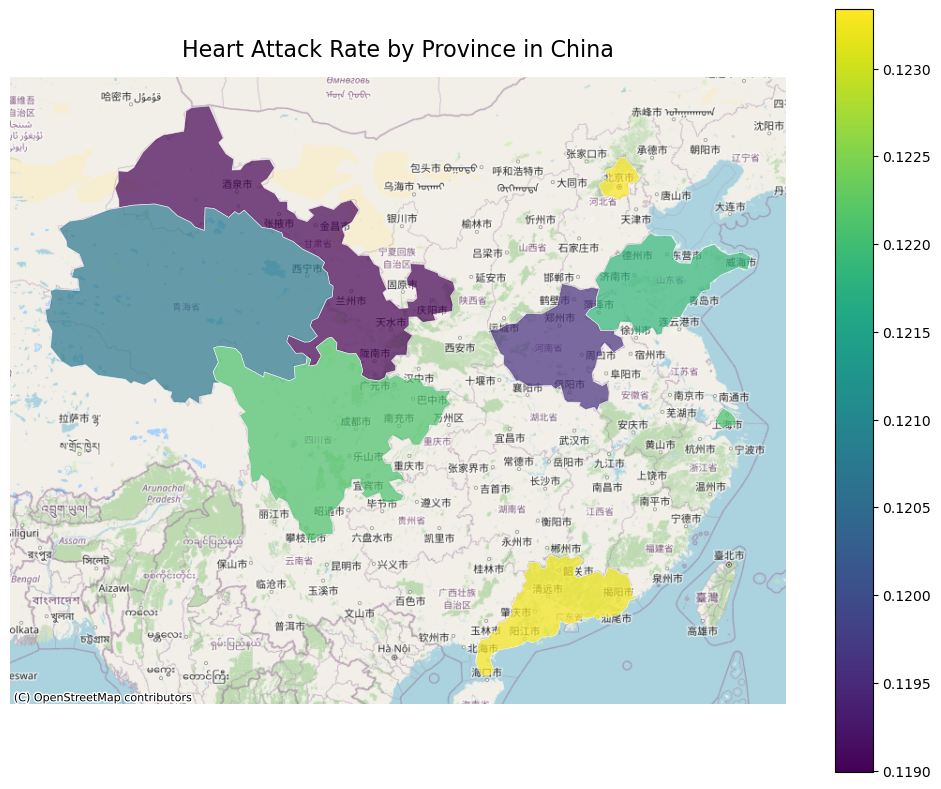

In [40]:
# Overlay the analysis with a map of the current provinces 
# in the region
fig, ax = plt.subplots(figsize=(10, 8))

# Choropleth on top
# The alpha level is the transparency value
gdf_map_web.plot(
    column="heart_attack_rate",
    legend=True,
    alpha=0.7,       
    edgecolor="white",
    linewidth=0.5,
    ax=ax
)

# Add basemap behind it
# and we can try different provinces in the mapnik if wanted
cx.add_basemap(
    ax,
    source=cx.providers.OpenStreetMap.Mapnik  
)

ax.set_title("Heart Attack Rate by Province in China", fontsize=16, pad=15)
ax.axis("off")
plt.tight_layout()
plt.show()


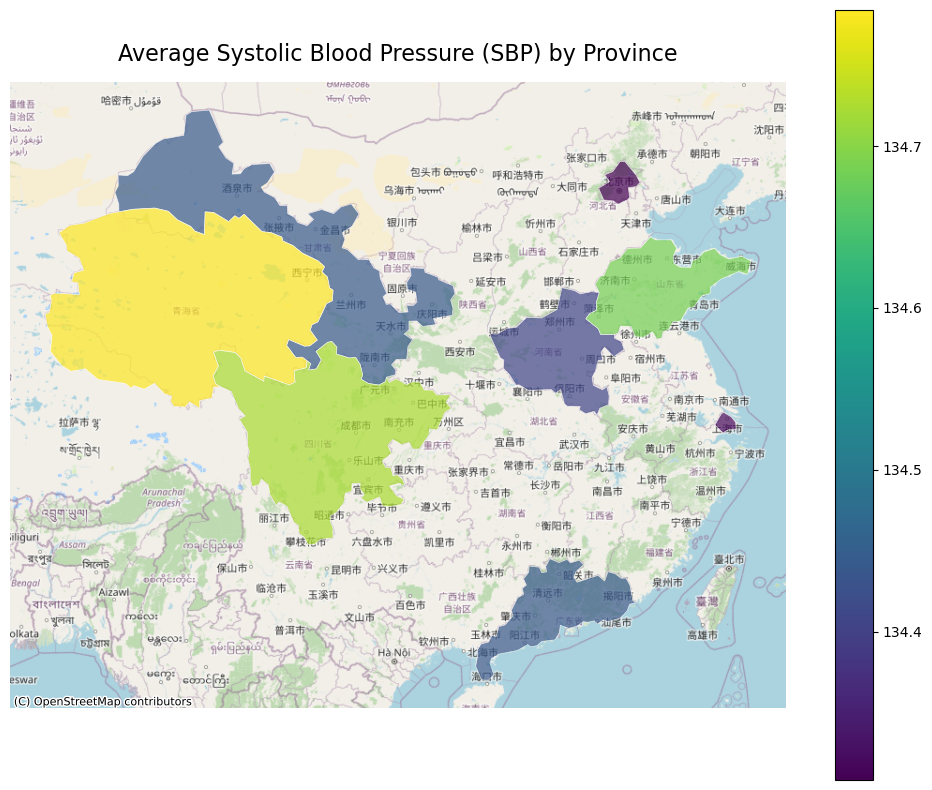

In [42]:
# Overlay the analysis with a map of the current provinces 
# in the region
fig, ax = plt.subplots(figsize=(10, 8))

# Choropleth on top
# The alpha level is the transparency value
gdf_map_web.plot(
    column="mean_sbp",
    legend=True,
    alpha=0.7,
    edgecolor="white",
    linewidth=0.5,
    ax=ax
)

# Add basemap behind it
# and we can try different provinces in the mapnik if wanted
cx.add_basemap(ax, source=cx.providers.OpenStreetMap.Mapnik)

ax.set_title("Average Systolic Blood Pressure (SBP) by Province", fontsize=16, pad=15)
ax.axis("off")
plt.tight_layout()
plt.show()


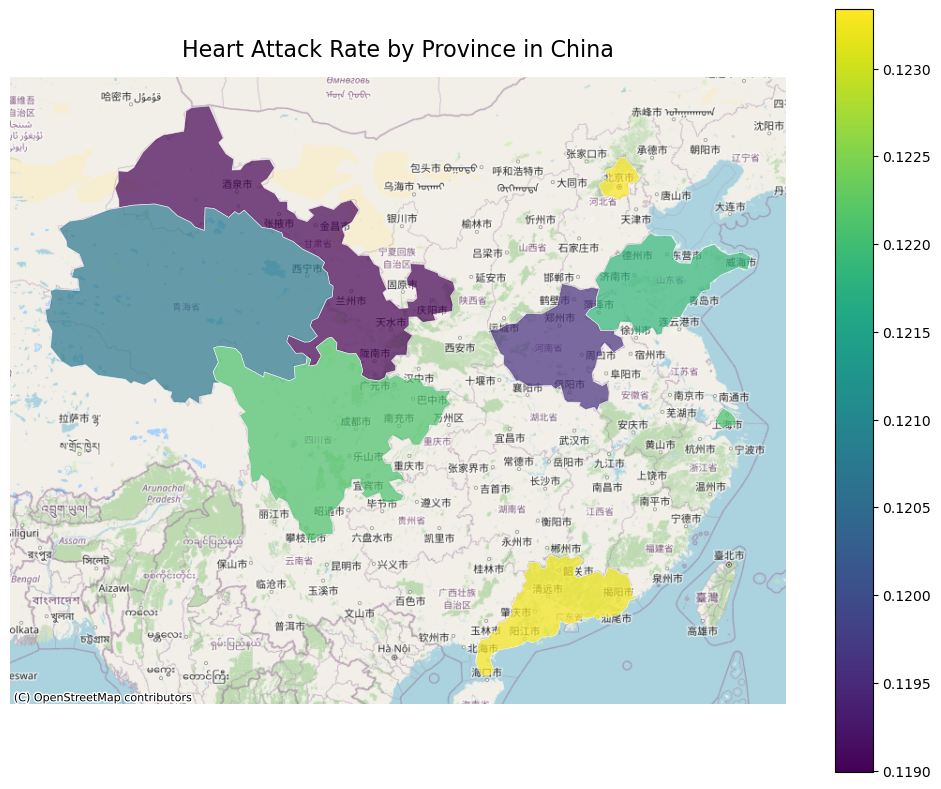

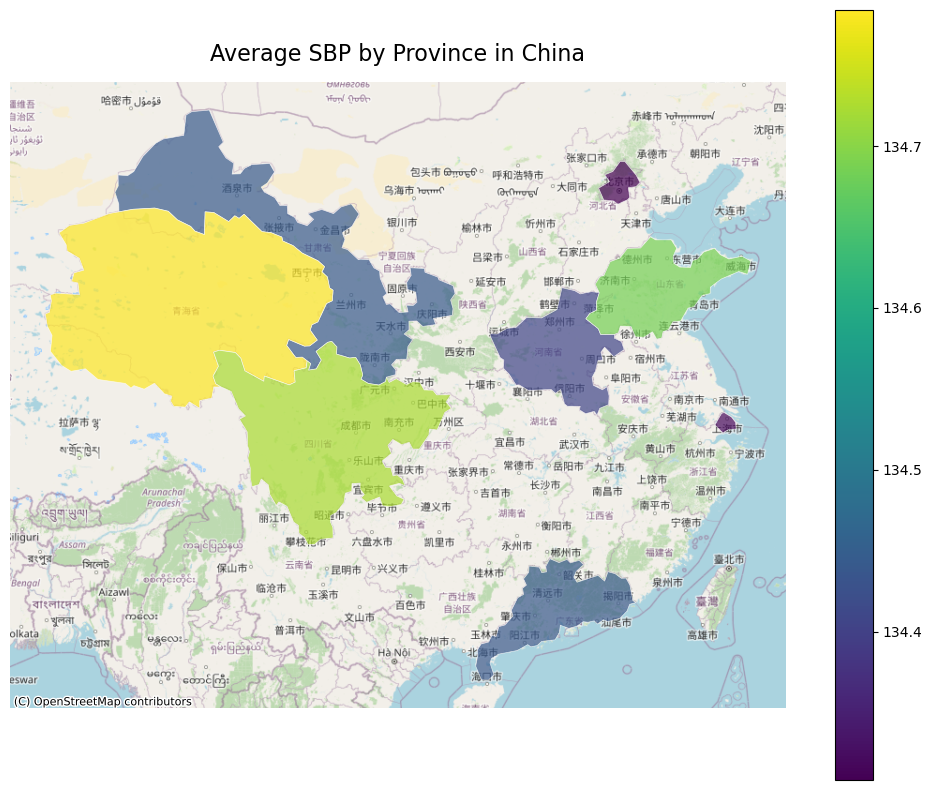

In [44]:
# Save the updated basemaps 
# Heart Attack Rate + basemap
fig, ax = plt.subplots(figsize=(10, 8))

gdf_map_web.plot(
    column="heart_attack_rate",
    legend=True,
    alpha=0.7,
    edgecolor="white",
    linewidth=0.5,
    ax=ax
)

cx.add_basemap(ax, source=cx.providers.OpenStreetMap.Mapnik)

ax.set_title("Heart Attack Rate by Province in China", fontsize=16, pad=15)
ax.axis("off")
plt.tight_layout()

# save figure
fig.savefig("../reports/figures/heart_attack_rate_with_basemap.png",
            dpi=300, bbox_inches="tight")

# Check to see if what is saved
plt.show()


# Mean SBP + basemap
fig, ax = plt.subplots(figsize=(10, 8))

gdf_map_web.plot(
    column="mean_sbp",
    legend=True,
    alpha=0.7,
    edgecolor="white",
    linewidth=0.5,
    ax=ax
)

cx.add_basemap(ax, source=cx.providers.OpenStreetMap.Mapnik)

ax.set_title("Average SBP by Province in China", fontsize=16, pad=15)
ax.axis("off")
plt.tight_layout()

fig.savefig("../reports/figures/mean_sbp_with_basemap.png",
            dpi=300, bbox_inches="tight")

# Check to see what is saved
plt.show()

## 2) Combining Heart_attack_china with GIS Data

Create a dictionary of the various first level administrative regions (autonomouss, autonomous regions, and municipalities) with their locations for Urban and Rural locations.  As discussed in the proposal, the locations used will be the geodesic centers of:
* The administrative region for Rural data points.
* The largest city in the autonomous for Urban data points.

In order to construct this dictionary the following steps must be undertaken:
1) Retrieve a list of the largest city in each administrative region.
2) Obtain GIS data describing the autonomous and city boundaries.
3) Determine the geodesic center of each element.
4) Save off results as a GeoJson

Direct-administered municipalities will be treated as autonomouss for the purposes of this data.

### Obtain a list of the largest city in each province

In [48]:
import requests
from bs4 import BeautifulSoup
from pprint import pprint

def get_parsed_page(title: str) -> list:
    """Imported from Assignment 3 - Function retrieves and parses a Wikipedia page given a title"""
    # Create the User-Agent tag to comply with Wikipedia's TOS
    headers = { "User-Agent": "Drexel_Disc_511/1.0 (srs359@drexel.edu)" }

    # Make the Request
    response = requests.get("https://en.wikipedia.org/api/rest_v1/page/html/" + title, headers=headers)
    
    if response.status_code != 200:
        print(f"Status Code: {response.status_code}")
        return None
    
    original_response: str = response.text

    # Parse the result
    parsed_response = BeautifulSoup(original_response, "html.parser")
    
    return [original_response, parsed_response]

def parse_wiki_table(table, primary_key: str, secondary_key: str, print_trace: bool = False) -> dict:
    """parses the given table into dictionary"""
    r_value: dict = {}

    # Get the Header and store for use
    header_list = []
    # print(table)

    header_row = table.find("tr")
    for tag in header_row.find_all("th"):
        header_list.append(tag.get_text())

    if print_trace:
        print(f"Header: {header_list}")

    # If the given primary key isn't in the table, use the first column as the primary
    primary_key_idx = 0
    if primary_key in header_list:
        primary_key_idx = header_list.index(primary_key)

    if secondary_key not in header_list:
        return
    
    secondary_key_idx = header_list.index(secondary_key)
    if print_trace:
        print(f"Indices: {primary_key_idx} | {secondary_key_idx}")

    # Get the Rows
    for row in table.find_all("tr")[1:]:
        row_values = row.find_all(["th","td"])
        row_length = len(row_values)

        if print_trace:
            print(row)
            print(f"Row length of {len(row_values)}")
        if row_length < min(primary_key_idx, secondary_key_idx):
            if print_trace:
                print("Row too short")
                print(row)
            break

        # Retrieve the values
        row_key = row_values[primary_key_idx].get_text()
        if len(header_list) > len(row_values):
            if print_trace:
                print(f"Offsetting Secondary Key: {len(header_list)} | {len(row_values)}")
            value_key = row_values[secondary_key_idx-1].get_text()
        else:
            value_key = row_values[secondary_key_idx].get_text()

        # Add this row to the return dictionary
        if print_trace:
            print(f"Row: {row_key} | {value_key}")
        r_value[row_key] = value_key

    return r_value

province_page_title = "Provinces of China"

province_page = get_parsed_page(province_page_title)

province_dict: dict = {}

if province_page is not None:
    # Find the province table
    for table in province_page[1].body.find_all('table'):
        # "wikitable sortable jquery-tablesorter"
        if "wikitable" in table.get("class"):
            # print(f"Class: {table.get("class")}")
            province_dict = parse_wiki_table(table, "Province", "Largest city")
            print(province_dict)
            # We found the table, now exit
            break

{'Hebei': 'Shijiazhuang', 'Shanxi': 'Taiyuan', 'Liaoning': 'Shenyang', 'Jilin': 'Changchun', 'Heilongjiang': 'Harbin', 'Jiangsu': 'Suzhou', 'Zhejiang': 'Hangzhou', 'Anhui': 'Hefei', 'Fujian[b]': 'Quanzhou', 'Jiangxi': 'Ganzhou', 'Shandong': 'Linyi', 'Henan': 'Zhengzhou', 'Hubei': 'Wuhan', 'Hunan': 'Changsha', 'Guangdong[c]': 'Guangzhou', 'Hainan[d]': 'Haikou', 'Sichuan': 'Chengdu', 'Guizhou': 'Zunyi', 'Yunnan': 'Kunming', 'Shaanxi': "Xi'an", 'Gansu': 'Lanzhou', 'Qinghai': 'Xining', 'Taiwan[f]': 'New Taipei City'}


### Obtain the largest city in each Autonomous Region

In [51]:
autonomous_page_title = "Autonomous regions of China"

autonomous_page = get_parsed_page(autonomous_page_title)

autonomous_dict: dict = {}

if autonomous_page is not None:
    # Find the autonomous table
    for table in autonomous_page[1].body.find_all('table'):
        # "wikitable sortable jquery-tablesorter"
        if "wikitable" in table.get("class"):
            # print(f"Class: {table.get("class")}")
            autonomous_dict = parse_wiki_table(table, "Name in English", "Capital")
            # Clean up the entry
            for key, value in autonomous_dict.items():
                position = value.find("(")
                autonomous_dict[key] = value[:position]

            pprint(autonomous_dict)
            # We found the table, now exit
            break

{'Guangxi Zhuang Autonomous Region': 'Nanning',
 'Inner Mongolia Autonomous Region': 'Hohhot',
 'Ningxia Hui Autonomous Region': 'Yinchuan',
 'Tibet Autonomous Region': 'Lhasa',
 'Xinjiang Uygur Autonomous Region': 'Ürümqi'}


### Obtain the City Seat in each independent Municipalities
Despite what one would think at first glance, there are rural areas within the Municipalities.  This is evidenced by several data points in our original set being labeled as living in Beijing and being from Rural areas.

In [54]:
municipality_page_title = "Direct-administered municipality"

municipality_page = get_parsed_page(municipality_page_title)

municipality_dict: dict = {}

if municipality_page is not None:
    # Find the municipality table
    for table in municipality_page[1].body.find_all('table'):
        if "wikitable" in table.get("class"):
            # print(f"Class: {table.get("class")}")
            municipality_dict = parse_wiki_table(table, "Division name", "City seat")

            pprint(municipality_dict)
            # We found the table, now exit
            break

{'Beijing': 'Tongzhou',
 'Chongqing': 'Yuzhong',
 'Shanghai': 'Huangpu',
 'Tianjin': 'Hexi'}


### Determine the geodesic center of each element

In [73]:
!pip install osmnx

import overpy
osm_api = overpy.Overpass()

import osmnx as ox
import geopandas as gpd

ox.settings.timeout = 60
ox.settings.use_cache = True

def get_centroid(place_name) -> tuple:
    geodataframe = ox.geocode_to_gdf(place_name)#, tags={"admin_level": "4"})
    
    if geodataframe is None:
        print(f"Unable to find {place_name}")
        return None
    else:
        centroid = geodataframe.to_crs('epsg:4087').centroid.to_crs(geodataframe.crs)
        # print(f"Geodesic Center (Centroid) of {place_name}:\\n{centroid}")
        # coordinates_tuple = tuple(centroid[0].coords)[0]
        return tuple(centroid[0].coords)[0]

def process_first_level_division(division_dict: dict, print_trace: bool = False) -> dict:
    """Processes a first level division dictionary and find the geodesic
       center of the division and the sub-area"""
    r_value: dict = {}

    for division, capital in division_dict.items():
        try:
            # Get Rural value
            place_name = division + ", China"
            longitude, latitude = get_centroid(place_name)

            if print_trace:
                print(f"Geodesic Center (Centroid) of {place_name}: {latitude}, {longitude}")

            # r_value[division]["Rural"] = (latitude, longitude)
            rural = (latitude, longitude)

            # Get Urban value
            place_name = capital + ", China"
            longitude, latitude = get_centroid(place_name)
            if print_trace:
                print(f"Geodesic Center (Centroid) of {place_name}: {latitude}, {longitude}")

            # r_value[division]["Urban"] = (latitude, longitude) 
            urban = (latitude, longitude)
            
            if rural is not None and urban is not None:
                r_value[division] = { "Rural": rural, "Urban": urban }

        except ValueError as exc:
            print(f"ERROR: {exc}")
            continue
        
        except TypeError as exc:
            print(f"ERROR: {exc}")
            continue

    return r_value

province_centers = process_first_level_division(province_dict)
# pprint(f"Province Centers: {province_centers}")

autonomous_centers = process_first_level_division(autonomous_dict)
# pprint(f"Autonomous Centers: {autonomous_centers}")

municipality_centers = process_first_level_division(municipality_dict)
# pprint(f"Municipality Centers: {municipality_centers}")

national_centroid_dict = province_centers | autonomous_centers | municipality_centers

pprint(national_centroid_dict)


ERROR: Nominatim did not geocode query 'Inner Mongolia Autonomous Region, China' to a geometry of type (Multi)Polygon.
{'Anhui': {'Rural': (31.82612180594919, 117.22585516559734),
           'Urban': (31.763470291977853, 117.35653738260042)},
 'Beijing': {'Rural': (40.17934377083946, 116.42072511464755),
             'Urban': (39.8028172130268, 116.73040605411093)},
 'Chongqing': {'Rural': (30.056887456977677, 107.87434458537238),
               'Urban': (29.552496348625272, 106.53732119431666)},
 'Fujian[b]': {'Rural': (26.921050184196794, 118.97877719471613),
               'Urban': (25.01456843633409, 118.43176992375948)},
 'Gansu': {'Rural': (37.885271404892414, 100.60167573925908),
           'Urban': (36.3549318961551, 103.63818297759768)},
 'Guangdong[c]': {'Rural': (22.583070598187074, 113.94535923595662),
                  'Urban': (23.335906551811707, 113.53831432088654)},
 'Guangxi Zhuang Autonomous Region': {'Rural': (23.727035595804804,
                                    

### Save off results as a GeoJson

In [78]:
!pip install geojson
import geojson
from geojson import Feature, FeatureCollection, Point, dump
import os

def create_feature(key: str, value: dict, rural_or_urban: str) -> Feature:
    centroid_pnt = Point(value[rural_or_urban])
    properties = {
        "Province": key,
        "Rural_or_Urban": rural_or_urban
    }

    return Feature(geometry=centroid_pnt, properties=properties)

feature_list: list = []

for key, value in national_centroid_dict.items():
    # Create a feature from the Urban entry    
    feature_list.append(create_feature(key, value, "Rural"))

    # Create a feature from the Rural entry
    feature_list.append(create_feature(key, value, "Urban"))

collection = FeatureCollection(feature_list)

file_location = "../data/processed/urban_or_rural_centroids.geojson"

with open(file_location, 'w') as f:
    dump(collection, f)

print(f"GeoJson successfully written to {os.path.abspath(file_location)}")
pprint(collection)

GeoJson successfully written to /Users/royphelps/Library/CloudStorage/OneDrive-DrexelUniversity/DSCI 511-900/Colab Notebooks/DSCI-511-Project/data/processed/urban_or_rural_centroids.geojson
{"features": [{"geometry": {"coordinates": [39.533892, 116.230883], "type": "Point"}, "properties": {"Province": "Hebei", "Rural_or_Urban": "Rural"}, "type": "Feature"}, {"geometry": {"coordinates": [38.130477, 114.439754], "type": "Point"}, "properties": {"Province": "Hebei", "Rural_or_Urban": "Urban"}, "type": "Feature"}, {"geometry": {"coordinates": [37.571595, 112.289301], "type": "Point"}, "properties": {"Province": "Shanxi", "Rural_or_Urban": "Rural"}, "type": "Feature"}, {"geometry": {"coordinates": [37.959172, 112.315685], "type": "Point"}, "properties": {"Province": "Shanxi", "Rural_or_Urban": "Urban"}, "type": "Feature"}, {"geometry": {"coordinates": [40.989143, 122.488067], "type": "Point"}, "properties": {"Province": "Liaoning", "Rural_or_Urban": "Rural"}, "type": "Feature"}, {"geometry"

In [80]:
import pandas as pd
import geopandas as gpd
from pathlib import Path

# Load your analysis-ready Heart Attack dataset
analysis_path = Path("../data/processed/heart_attack_china_analysis_ready.csv")
df_analysis = pd.read_csv(analysis_path)

# Load the centroid GeoJSON urban or rural centroids
centroids_path = Path("../data/processed/urban_or_rural_centroids.geojson")
gdf_centroids = gpd.read_file(centroids_path)

gdf_centroids.head()


,Province,Rural_or_Urban,geometry
0,Hebei,Rural,POINT (39.53389 116.23088)
1,Hebei,Urban,POINT (38.13048 114.43975)
2,Shanxi,Rural,POINT (37.5716 112.2893)
3,Shanxi,Urban,POINT (37.95917 112.31568)
4,Liaoning,Rural,POINT (40.98914 122.48807)


In [82]:
# Clean province names in centroids remove [b], [note], etc.
gdf_centroids["province_clean"] = (
    gdf_centroids["Province"]
    .str.replace(r"\[.*\]", "", regex=True)  
    .str.strip()
)

# Normalize Rural/Urban labels
gdf_centroids["urban_rural_clean"] = gdf_centroids["Rural_or_Urban"].str.strip()


In [84]:
# Set the columns for Province and Rural or Urban
PROV_COL = "Province"       
UR_COL   = "Rural_or_Urban"    

# Clean and make urban Urban and rural Rural
df_analysis["province_clean"] = df_analysis[PROV_COL].str.strip()
df_analysis["urban_rural_clean"] = (
    df_analysis[UR_COL]
    .str.strip()
    .str.capitalize()  
)

# Check the columns
df_analysis.columns



Index(['Patient_ID', 'Age', 'Gender', 'Smoking_Status', 'Hypertension',
       'Diabetes', 'Obesity', 'Cholesterol_Level', 'Air_Pollution_Exposure',
       'Physical_Activity', 'Diet_Score', 'Stress_Level',
       'Alcohol_Consumption', 'Family_History_CVD', 'Healthcare_Access',
       'Rural_or_Urban', 'Region', 'Province', 'Hospital_Availability',
       'TCM_Use', 'Employment_Status', 'Education_Level', 'Income_Level',
       'SBP', 'Chronic_Kidney_Disease', 'Previous_Heart_Attack',
       'CVD_Risk_Score', 'Heart_Attack', 'Gender_simple', 'SBP_missing',
       'SBP_hypertensive', 'WHO_Mean_Blood_Pressure_SEX_BTSX_latest',
       'WHO_Mean_Blood_Pressure_SEX_MLE_latest',
       'WHO_Mean_Blood_Pressure_SEX_FMLE_latest', 'province_clean',
       'urban_rural_clean'],
      dtype='object')

In [86]:
# Merge the health risk features plus the proince and urban rural clean versions
# and left joing to keep all rows form the heart attack datset
df_merged = df_analysis.merge(
    gdf_centroids[["province_clean", "urban_rural_clean", "geometry"]],
    on=["province_clean", "urban_rural_clean"],
    how="left"   
)

# Turn into a GeoDataFrame
gdf_merged = gpd.GeoDataFrame(df_merged, geometry="geometry", crs="EPSG:4326")

gdf_merged.head()


,Patient_ID,Age,Gender,Smoking_Status,Hypertension,Diabetes,Obesity,Cholesterol_Level,Air_Pollution_Exposure,Physical_Activity,...,Heart_Attack,Gender_simple,SBP_missing,SBP_hypertensive,WHO_Mean_Blood_Pressure_SEX_BTSX_latest,WHO_Mean_Blood_Pressure_SEX_MLE_latest,WHO_Mean_Blood_Pressure_SEX_FMLE_latest,province_clean,urban_rural_clean,geometry
0,1,55,Male,Non-Smoker,0,0,1,Normal,High,High,...,0,M,False,0,23.013535,26.032547,NaN,Beijing,Rural,POINT (40.17934 116.42072)
1,2,66,Female,Smoker,1,0,0,Low,Medium,High,...,0,F,False,1,23.013535,NaN,19.842985,Qinghai,Urban,POINT (36.82856 101.43736)
2,3,69,Female,Smoker,0,0,0,Low,Medium,High,...,0,F,False,1,23.013535,NaN,19.842985,Henan,Rural,POINT (33.88184 113.61431)
3,4,45,Female,Smoker,0,1,0,Normal,Medium,Low,...,0,F,False,1,23.013535,NaN,19.842985,Qinghai,Rural,POINT (35.84817 96.43002)
4,5,39,Female,Smoker,0,0,0,Normal,Medium,Medium,...,0,F,False,1,23.013535,NaN,19.842985,Guangdong,Urban,POINT (23.33591 113.53831)


In [88]:
# Save the merged dataset 
out_path = Path("../data/processed/heart_attack_china_with_centroids.geojson")
gdf_merged.to_file(out_path, driver="GeoJSON")
print(f"Saved merged centroid dataset to: {out_path.resolve()}")


Saved merged centroid dataset to: /Users/royphelps/Library/CloudStorage/OneDrive-DrexelUniversity/DSCI 511-900/Colab Notebooks/DSCI-511-Project/data/processed/heart_attack_china_with_centroids.geojson


In [90]:
# Check the merged dataset's geometry
gdf_merged.geometry.isna().value_counts()


geometry
False    239266
Name: count, dtype: int64

In [92]:
# Check the merged dataset's bounds
gdf_merged.total_bounds


array([ 22.583071,  96.430021,  40.179344, 121.873986])

In [94]:
import geopandas as gpd

# Geopandas uses standard lon,lat: x=longitude, y=latituds
# the GEOJSON was swapped. Reverse them bakck. 
# From the existing gdf_merged
gdf_merged["lat"] = gdf_merged.geometry.x   # x currently holds latitude
gdf_merged["lon"] = gdf_merged.geometry.y   # y currently holds longitude

# Rebuild geometry with correct order: (lon, lat)
gdf_merged["geometry"] = gpd.points_from_xy(
    gdf_merged["lon"], # x is now lon
    gdf_merged["lat"]  # y is now lat
)

# Set proper CRS
# CRS is standard lat,lon in degrees use by GPS, OpenStreetMap...
# example: epsg=4326 is WGS84
gdf_merged.set_crs(epsg=4326, inplace=True)

# Check bounds again
print(gdf_merged.total_bounds)


[ 96.430021  22.583071 121.873986  40.179344]


In [96]:
gdf_plot = gdf_merged[~gdf_merged.geometry.isna()].copy()
print(gdf_plot.total_bounds)


[ 96.430021  22.583071 121.873986  40.179344]


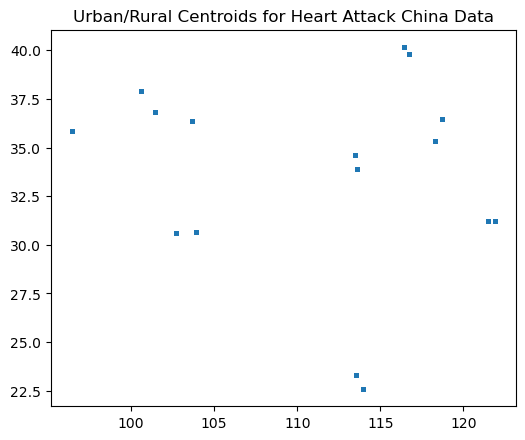

In [98]:
# Plotting library import
import matplotlib.pyplot as plt

# Only where the geometry is not, ~, NaN
gdf_plot = gdf_merged[~gdf_merged.geometry.isna()].copy()

# Create a 6x6 map that plots the points
fig, ax = plt.subplots(figsize=(6, 6))
gdf_plot.plot(ax=ax, markersize=5)
ax.set_title("Urban/Rural Centroids for Heart Attack China Data")
plt.show()


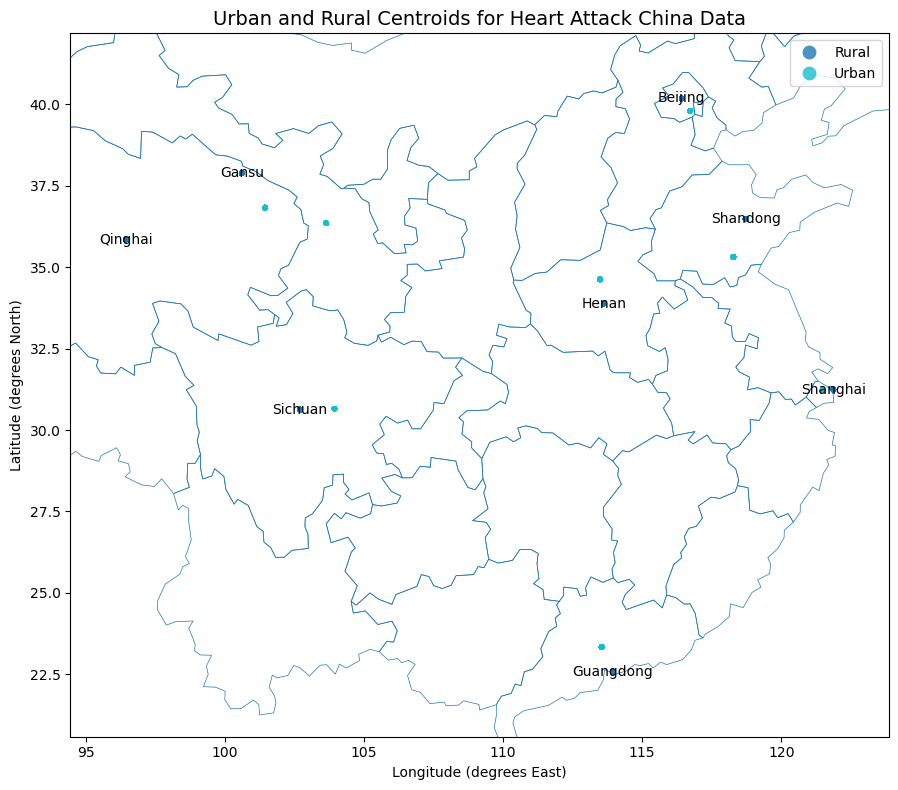

Figure saved to: ../reports/figures/urban_rural_centroids_with_labels.png


In [100]:
# Load China provinces polygons comes from Kaggle download. 
geojson_path = "../data/external/gadm36_CHN_1.json"  # adjust path if needed
gdf_prov = gpd.read_file(geojson_path)
gdf_prov = gdf_prov.to_crs(epsg=4326)  # match CRS of your centroids

# Keep only rows with a valid centroid geometry
gdf_plot = gdf_merged[~gdf_merged.geometry.isna()].copy()

# Create figure and axes
fig, ax = plt.subplots(figsize=(10, 8))

# Plot China province outlines as a light background
gdf_prov.boundary.plot(ax=ax, linewidth=0.5)

# Plot centroids, colored by Urban vs Rural
gdf_plot.plot(
    ax=ax,
    column="urban_rural_clean",   # 'urban' / 'rural'
    categorical=True,
    legend=True,
    markersize=8,
    alpha=0.8
)

# Add province labels
# Take one point per province (to avoid double labels from urban/rural)
# Just keep the first row per province_clean
label_points = (
    gdf_plot
    .sort_values("urban_rural_clean")           # so 'rural' might come first
    .drop_duplicates(subset="province_clean")   # one label per province
)

for _, row in label_points.iterrows():
    x = row.geometry.x
    y = row.geometry.y
    name = row["province_clean"]

    ax.text(
        x, y,
        name,
        fontsize=10,
        ha="center",
        va="center"
    )

# Titles and axis labels
ax.set_title("Urban and Rural Centroids for Heart Attack China Data", fontsize=14)
ax.set_xlabel("Longitude (degrees East)")
ax.set_ylabel("Latitude (degrees North)")

# Optional: zoom the map nicely around your data
minx, miny, maxx, maxy = gdf_plot.total_bounds
pad_x, pad_y = 2, 2  # degrees of padding
ax.set_xlim(minx - pad_x, maxx + pad_x)
ax.set_ylim(miny - pad_y, maxy + pad_y)

plt.tight_layout()


# Export the figure
fig_dir = Path("../reports/figures")
fig_dir.mkdir(parents=True, exist_ok=True)
fig_path = fig_dir / "urban_rural_centroids_with_labels.png"
fig.savefig(fig_path, dpi=300, bbox_inches="tight")

plt.show()

print(f"Figure saved to: {fig_path}")


# Project References & Data Sources

This project integrates medical data, geographic reference data, and programmatically generated spatial data to support analysis and visualization.

---

## 1. Heart Attack China Dataset
**Source:** Kaggle  
**Description:**  
Dataset containing provincial-level heart attack indicators and related health factors across China, including urban vs rural classification.

Used for:
- Primary analysis
- Risk-factor exploration
- Aggregations and statistical analysis

Original source credited on Kaggle.

---

## 2. China Province Boundaries (GADM v3.6)
**Source:** Kaggle (GADM Database of Global Administrative Areas)  
**File:** `gadm36_CHN_1.json`  

**Description:**  
This dataset provides official geographic boundaries for China’s first-level administrative divisions (provinces). The dataset was used strictly for visualization and spatial context.

Used for:
- Background map layer
- Geographic reference when plotting centroids

Reference:
https://gadm.org

---

## 3. Wikipedia – Administrative Divisions
**Source:** Wikipedia  

Used to extract province and capital information:

| Page | Purpose |
|------|---------|
| *Provinces of China* | Province names and largest cities |
| *Autonomous regions of China* | Autonomous regions and capitals |
| *Direct-administered municipalities* | Municipalities and capital cities |

Data accessed via Wikipedia REST API and parsed programmatically.

---

## 4. OpenStreetMap / OSMnx
**Source:** OpenStreetMap via Python OSMnx library  
**Library:** `osmnx`  

**Description:**  
Used to geocode province names and capitals and extract centroid coordinates for:

- Rural province centers
- Urban city centers

Used for:
- Generating custom GeoJSON centroid dataset
- Latitude/Longitude calculations

Website:
https://www.openstreetmap.org  
Library documentation:
https://osmnx.readthedocs.io

---

## 5. Custom Spatial Dataset (This Project)
**File:** `urban_or_rural_centroids.geojson`  

**Description:**  
This GeoJSON file was **generated within this project** using:

- Wikipedia data
- OpenStreetMap geocoding
- GeoPandas
- OSMnx

Contains:
- Province name
- Urban vs Rural flag
- Longitude / Latitude coordinate pairs

Purpose:
- Provides centroid coordinates for each province and urban / rural region
- Enables geospatial visualization

---

## 6. Python Libraries Used

| Library | Purpose |
|----------|----------|
| pandas | Data processing and merging |
| geopandas | Spatial analysis and mapping |
| osmnx | Geocoding and centroid extraction |
| shapely | Geometry creation |
| matplotlib | Plotting and visualization |
| beautifulsoup4 | Web scraping and HTML parsing |
| requests | API requests |
| geojson | Writing GeoJSON output |

---

## Notes on Data Usage

All external datasets were used for academic purposes only and for demonstration and learning within a university project context.

Code used to generate derived datasets is included within this repository to ensure reproducibility.


# Interpretation of the Map

This visualization shows the geographic reference structure of the dataset.

Each province includes two reference points:
- Urban location (capital city centroid)
- Rural location (province centroid)

These points do NOT represent heart attack events, severity, risk, or frequency.

They exist to:
- Validate geographic alignment
- Provide spatial reference context
- Support future geo-analysis and spatial grouping
- Confirm real-world validity of provincial data mapping

No health outcomes are encoded in color, size, or location.
This map illustrates geography only, not medical data.
